In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings
import random
from scipy import stats
from scipy.stats import pearsonr
import statsmodels.api

# Permet de retirer les warning message du a l'import des fichier excel.xlsx
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

# permet d'afficher toute les colonne d'un head
pd.set_option('max_columns', None)

# permet d'afficher toute les ligne d'un head
# pd.set_option('max_rows', None)

# Reset de l'affichage des colonnes et ligne
# pd.reset_option('max_columns')
pd.reset_option('max_rows')

# Fonction

In [2]:
# Je défini ma fonction pour check les doublons que je vais utiliser plus loin
def doublon(data):
    print(data.duplicated().sum(), 'doublons et', (~data.duplicated()).sum(), 'unique \n')

# Je crée cette fonction pour describe mes data
def check(*data):
    a = 0
    for data in data:
        a = a + 1
        # print('\\033[1m bold \\033[0m')
        print(f"\033[1m Data n°{a}: \033[0m \n\n {data.describe(include='all')}", end=' \n\n\n')

#fonction trimestre je definie des date max et mini sur none, si je les rentre pas elle sortirons la plus petite pour mini et la plus grande pour max
def trimestre(data, min_date=None, max_date=None):
    if min_date is None:
        min_date = data.year_month_day.min()
    if max_date is None:
        max_date = data.year_month_day.max()
    # je return mon data avec un filtre sur ma colonne 'YMD'
    return data[(data['year_month_day'] >= min_date) & (data['year_month_day'] <= max_date)].sort_values(by='year_month_day')

#je crée cette fonction pour afficher le chiffre d'affaires sur plusieur data
def chiffre_daffaires(*data, date1, date2):
    date1 = date1
    date2 = date2
    for i in data:
        date1 = date1 + 1
        print(f"Nombre de ligne de l'année {date1} : {len(i):,}", end='\n')
    print("\n")
    for i in data:
        date2 = date2 + 1
        print(f"Chiffre d'affaires {date2} : {round(i['price'].sum()):,}€", end='\n') # je fait la somme de mon chiffe d'affaires
    return

def courbe_lorenz(data,col):
    dep = data[col]
    n = len(dep)
    lorenz = np.cumsum(np.sort(dep)) / dep.sum()
    lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0
    AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
    S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
    gini = round(2*S,2)
    print(gini)
    plt.figure(figsize=(12,8))
    xaxis = np.linspace(0-1/n,1+1/n,n+1) #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0. Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.
    plt.plot(xaxis,lorenz,drawstyle='steps-post')
    ident = [0, 1]
    plt.plot(ident,ident)
    plt.fill_between(np.linspace(0,1,len(lorenz)), lorenz)
    plt.text(0.2,0.8,"Gini ="+ str(gini))
    #plt.savefig('courblorenzClientPrix.png', dpi=300, transparent=True,bbox_inches='tight')
    plt.show()
    return

def cat_gender(data,sex,categ):
    f_cat_0 = data[(data['sex'] == sex) & (data['price'] > 0) & (data['categ'] == categ)]
    return len(f_cat_0)

def figS(a,b):
    plt.figure(figsize=(a,b))

var_color = ['teal','firebrick','navy','seagreen','darkmagenta','darkorange','saddlebrown','darkslategray','cadetblue','lavender','darkorchid']
#random.shuffle(var_color)

In [3]:
plt.style.use('classic')
# plt.style.use("dark_background")
plt.rcParams.update({'text.color': 'black'})

In [4]:
# J'importe mes data néttoyé
df_final = pd.read_csv("data\Data_drop_octobre.csv")
df_final.head()

,id_prod,date,session_id,client_id,year_month_day,year_buy,Ymonth,sex,birth,price,categ,year_old
0,0_1518,2022-05-20 13:21:29,s_211425,c_103,2022-05-20,2022,2022-05,f,1986,4.18,0.0,36
1,1_251,2022-02-02 07:55:19,s_158752,c_8534,2022-02-02,2022,2022-02,m,1988,15.99,1.0,34
2,0_1277,2022-06-18 15:44:33,s_225667,c_6714,2022-06-18,2022,2022-06,f,1968,7.99,0.0,54
3,2_209,2021-06-24 04:19:29,s_52962,c_6941,2021-06-24,2021,2021-06,m,2000,69.99,2.0,21
4,0_1509,2023-01-11 08:22:08,s_325227,c_4232,2023-01-11,2023,2023-01,m,1980,4.99,0.0,43


In [5]:
df_final.loc[df_final['Ymonth'] == '2021-10']

,id_prod,date,session_id,client_id,year_month_day,year_buy,Ymonth,sex,birth,price,categ,year_old


# Analyse avec le mois d'octobre en moins

# Chiffre D'affaires
Dans un premier temps, je vais avoir besoin de différents indicateurs et graphiques autour du
chiffre d'affaires. Peux-tu également regarder l’évolution dans le temps et mettre en place une
décomposition en moyenne mobile pour évaluer la tendance globale ?

In [6]:
# Je fait le total du chiffre d'affaires
df_ca = df_final['price'].sum()
print(f'Chiffre d\'Affaires : {round(df_ca):,}€')

Chiffre d'Affaires : 11,536,665€


In [7]:
# Ici je regarde sur quelle plage sont les date (2021-03-01 a 2023-02-28)
df_final.sort_values(by='year_month_day')

,id_prod,date,session_id,client_id,year_month_day,year_buy,Ymonth,sex,birth,price,categ,year_old
33569,0_1401,2021-03-01 15:19:15,s_322,c_2721,2021-03-01,2021,2021-03,m,1977,10.99,0.0,44
328305,0_1034,2021-03-01 22:37:39,s_464,c_3820,2021-03-01,2021,2021-03,f,1975,14.38,0.0,46
596477,0_1438,2021-03-01 15:06:14,s_304,c_7532,2021-03-01,2021,2021-03,f,1973,9.31,0.0,48
404628,0_1238,2021-03-01 00:53:57,s_26,c_1492,2021-03-01,2021,2021-03,m,1982,14.66,0.0,39
233546,1_734,2021-03-01 08:33:51,s_170,c_7565,2021-03-01,2021,2021-03,f,1988,24.28,1.0,33
...,...,...,...,...,...,...,...,...,...,...,...,...
318171,0_1396,2023-02-28 06:32:06,s_348087,c_7709,2023-02-28,2023,2023-02,m,1988,9.57,0.0,35
521710,1_464,2023-02-28 04:41:10,s_348064,c_2522,2023-02-28,2023,2023-02,f,1966,15.01,1.0,57
355595,1_457,2023-02-28 02:46:49,s_348013,c_4958,2023-02-28,2023,2023-02,m,1999,22.99,1.0,24
89531,1_369,2023-02-28 03:41:13,s_348035,c_1642,2023-02-28,2023,2023-02,m,1996,23.99,1.0,27


In [8]:
# Je crée une var ou j'y filtre suivant les date 2021,2022,2023
df_ca_21 = df_final[df_final['year_month_day'] <= '2021-12-31']
df_ca_22 = df_final[(df_final['year_month_day'] >= '2022-01-01') & (df_final['year_month_day'] <= '2022-12-31')]
df_ca_23 = df_final[(df_final['year_month_day'] >= '2023-01-01') & (df_final['year_month_day'] <= '2023-12-31')]

chiffre_daffaires(df_ca_21,df_ca_22,df_ca_23,date1=2020,date2=2020) # je fait la somme de mon chiffe d'affaires et de mon nombre de ligne
print(f"\nNombre de ligne total : {len(df_ca_21) + len(df_ca_22) + len(df_ca_23):,}") # je fait la somme total des rows pour etre sur de mes filtre
print(f"\nChiffre d'affaires total : {round(df_ca):,}") # je fait la somme total des rows pour etre sur de mes filtre

Nombre de ligne de l'année 2021 : 256,729
Nombre de ligne de l'année 2022 : 346,500
Nombre de ligne de l'année 2023 : 54,497


Chiffre d'affaires 2021 : 4,451,424€
Chiffre d'affaires 2022 : 6,110,776€
Chiffre d'affaires 2023 : 974,465€

Nombre de ligne total : 657,726

Chiffre d'affaires total : 11,536,665


## Histograme

### Histograme Trimestre

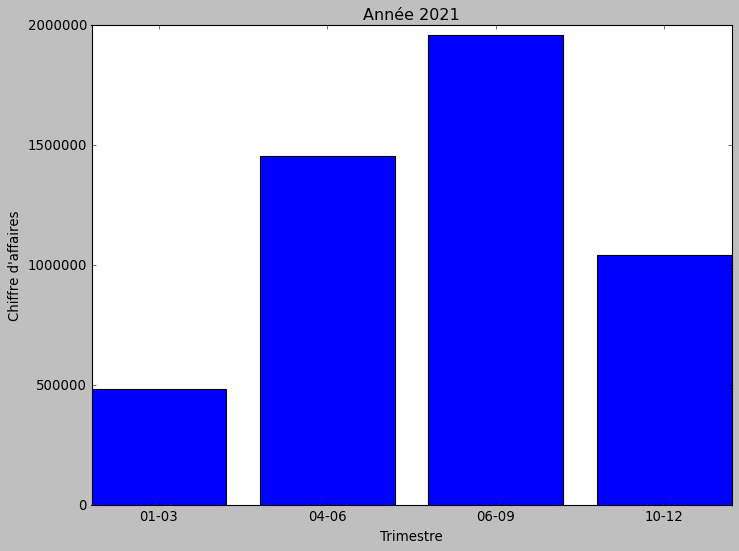

In [9]:
#je crée mes 4 variable pour les chiffre sur le trimestre
df_2021_trim1 = trimestre(df_final,min_date='2021-01-01', max_date='2021-03-31')
df_2021_trim2 = trimestre(df_final,min_date='2021-04-01', max_date='2021-06-30')
df_2021_trim3 = trimestre(df_final,min_date='2021-06-01', max_date='2021-09-31')
df_2021_trim4 = trimestre(df_final,min_date='2021-10-01', max_date='2021-12-31')

# Préparation de la figure
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
# mois pour le nom de mes histo
Annees = ['01-03', '04-06', '06-09','10-12']
# valeurs pour la somme du chiffre d'affaires sur chacun de mes trimestre
valeurs = [df_2021_trim1['price'].sum(), df_2021_trim2['price'].sum(), df_2021_trim3['price'].sum(), df_2021_trim4['price'].sum()]
# Affichage des données
ax.bar(Annees, valeurs)
plt.title('Année 2021')
plt.ylabel('Chiffre d\'affaires')  # Titre de l'axe y
plt.xlabel('Trimestre')
# plt.savefig('Trimestre2021moinsOctobre.png', dpi=300, transparent=True,bbox_inches='tight')
plt.show()

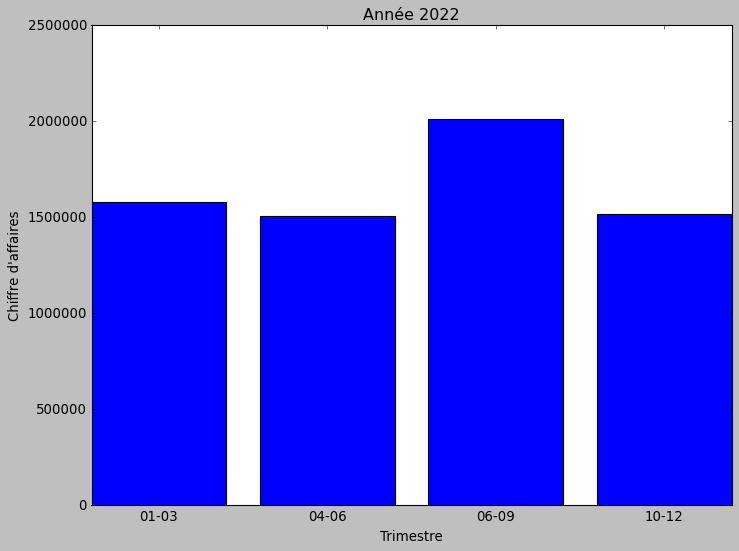

In [10]:
#je crée mes 4 variable pour les chiffre sur le trimestre
df_2022_trim1 = trimestre(df_final,min_date='2022-01-01', max_date='2022-03-31')
df_2022_trim2 = trimestre(df_final,min_date='2022-04-01', max_date='2022-06-30')
df_2022_trim3 = trimestre(df_final,min_date='2022-06-01', max_date='2022-09-31')
df_2022_trim4 = trimestre(df_final,min_date='2022-10-01', max_date='2022-12-31')

# Préparation de la figure
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
# mois pour le nom de mes histo
Annees = ['01-03', '04-06', '06-09','10-12']
# valeurs pour la somme du chiffre d'affaires sur chacun de mes trimestre
valeurs = [df_2022_trim1['price'].sum(), df_2022_trim2['price'].sum(), df_2022_trim3['price'].sum(), df_2022_trim4['price'].sum()]
# Affichage des données
ax.bar(Annees, valeurs)
plt.title('Année 2022')
plt.ylabel('Chiffre d\'affaires')  # Titre de l'axe y
plt.xlabel('Trimestre')
#plt.savefig('Trimestre2022.png', dpi=300, transparent=True,bbox_inches='tight')
plt.show()

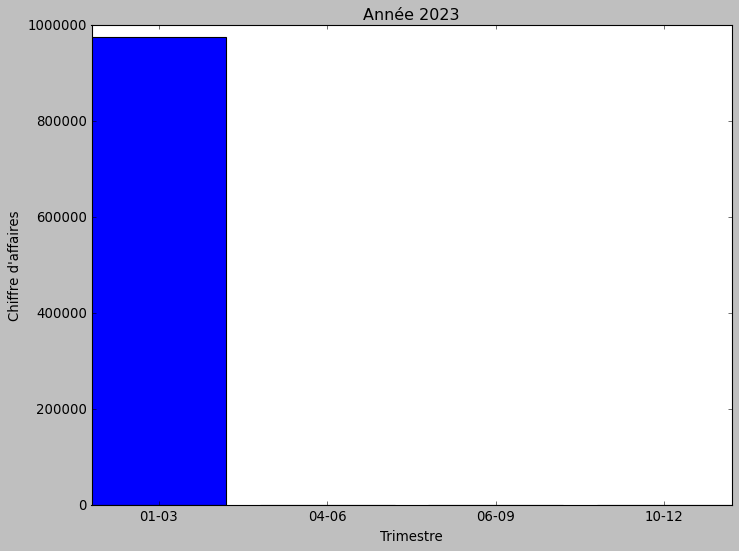

In [11]:
#je crée mes 4 variable pour les chiffre sur le trimestre
df_2023_trim1 = trimestre(df_final,min_date='2023-01-01', max_date='2023-03-31')
df_2023_trim2 = trimestre(df_final,min_date='2023-04-01', max_date='2023-06-30')
df_2023_trim3 = trimestre(df_final,min_date='2023-06-01', max_date='2023-09-31')
df_2023_trim4 = trimestre(df_final,min_date='2023-10-01', max_date='2023-12-31')

# Préparation de la figure
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
# mois pour le nom de mes histo
Annees = ['01-03', '04-06', '06-09','10-12']
# valeurs pour la somme du chiffre d'affaires sur chacun de mes trimestre
valeurs = [df_2023_trim1['price'].sum(), df_2023_trim2['price'].sum(), df_2023_trim3['price'].sum(), df_2023_trim4['price'].sum()]
# Affichage des données
ax.bar(Annees, valeurs)
plt.title('Année 2023')
plt.ylabel('Chiffre d\'affaires')  # Titre de l'axe y
plt.xlabel('Trimestre')
#plt.savefig('Trimestre2023.png', dpi=300, transparent=True,bbox_inches='tight')
plt.show()

### Histograme Total année

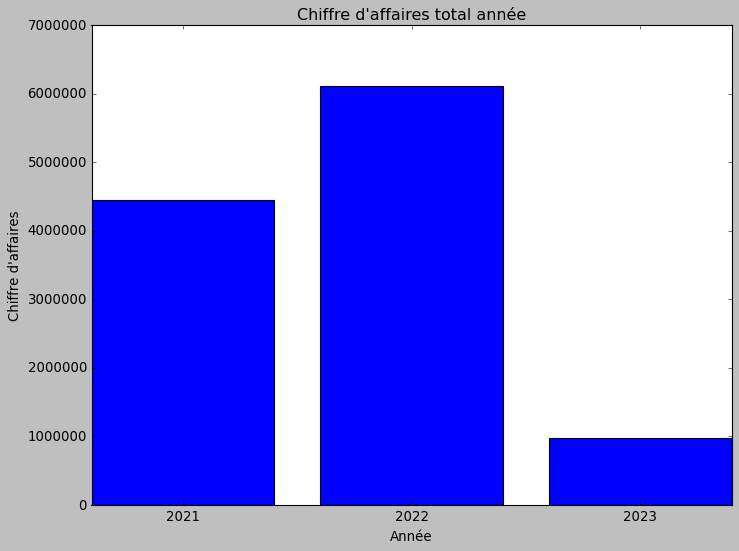

In [12]:
# Préparation de la figure
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
# année pour le nom de mes histo
Annees = ['2021', '2022', '2023']
# valeurs pour la somme du chiffre d'affaires sur chacun de mes années
valeurs = [df_ca_21['price'].sum(), df_ca_22['price'].sum(), df_ca_23['price'].sum()]
# Affichage des données
ax.bar(Annees, valeurs)
plt.title('Chiffre d\'affaires total année')
plt.ylabel('Chiffre d\'affaires')  # Titre de l'axe y
plt.xlabel('Année') # Titre de l'axe x
# plt.savefig('HistoallyearsmoinsOctobre.png', dpi=300, transparent=True,bbox_inches='tight')
plt.show()  # Affichage d'une courbe

### Histograme jour de la semaine

Lundi CA moyen : 18
Mardi CA moyen : 17
Mercredi CA moyen : 17
Jeudi CA moyen : 18
Vendredi CA moyen : 18
Samedi CA moyen : 18
Dimanche CA moyen : 17


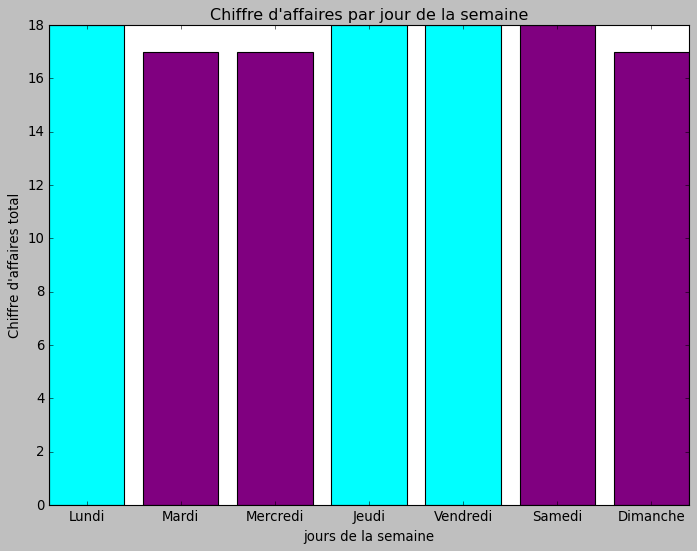

In [13]:
df_day_pl = df_final.copy()
# Je mets ma colonne au farmat date
df_day_pl['year_month_day'] = pd.to_datetime(df_final['year_month_day'])
# Je crée une colonne pour les jour de la semaine
df_day_pl['day'] = df_day_pl['year_month_day'].dt.day_name()

def dayp(data,col,day):
    return round(data[data[col] == day]['price'].mean())

print("Lundi CA moyen :",dayp(df_day_pl,'day','Monday'))
print("Mardi CA moyen :",dayp(df_day_pl,'day','Tuesday'))
print("Mercredi CA moyen :",dayp(df_day_pl,'day','Wednesday'))
print("Jeudi CA moyen :",dayp(df_day_pl,'day','Thursday'))
print("Vendredi CA moyen :",dayp(df_day_pl,'day','Friday'))
print("Samedi CA moyen :",dayp(df_day_pl,'day','Saturday'))
print("Dimanche CA moyen :",dayp(df_day_pl,'day','Sunday'))
# Préparation de la figure
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
# jour pour le nom de mes histo
days = ['Lundi','Mardi','Mercredi','Jeudi','Vendredi', 'Samedi', 'Dimanche']
# valeurs pour la somme du chiffre d'affaires sur chacun de mes jour. loc[jour de la semaine][somme des prix].sum()
valeurs = [dayp(df_day_pl,'day','Monday'),dayp(df_day_pl,'day','Tuesday'), dayp(df_day_pl,'day','Wednesday'), dayp(df_day_pl,'day','Thursday'), dayp(df_day_pl,'day','Friday'), dayp(df_day_pl,'day','Saturday'), dayp(df_day_pl,'day','Sunday')]
# Affichage des données
colors = ['cyan','purple','purple','cyan','cyan','purple','purple']
ax.bar(days, valeurs, color=colors)
plt.title('Chiffre d\'affaires par jour de la semaine')
plt.ylabel('Chiffre d\'affaires total')  # Titre de l'axe y
plt.xlabel('jours de la semaine') # Titre de l'axe x
plt.show()

## Chiffre d'affaires par genre et age

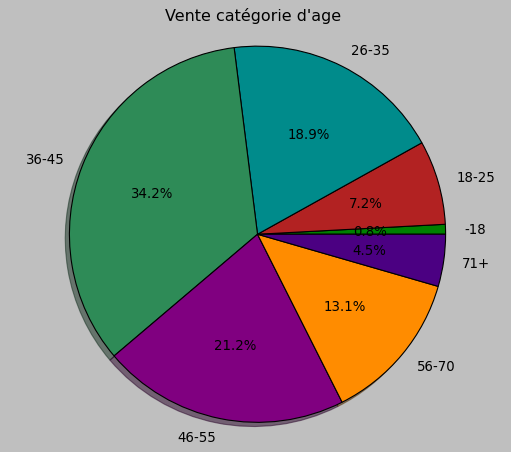

In [14]:
df_ca_und18 = df_final[(df_final['price'] > 0) & (df_final['year_buy'] - df_final['birth'] < 18)]
df_ca_18 = df_final[(df_final['price'] > 0) & (df_final['year_buy'] - df_final['birth'] >= 18) & (df_final['year_buy'] - df_final['birth'] <= 25)]
df_ca_26 = df_final[(df_final['price'] > 0) & (df_final['year_buy'] - df_final['birth'] >= 26) & (df_final['year_buy'] - df_final['birth'] <= 35)]
df_ca_36 = df_final[(df_final['price'] > 0) & (df_final['year_buy'] - df_final['birth'] >= 36) & (df_final['year_buy'] - df_final['birth'] <= 45)]
df_ca_46 = df_final[(df_final['price'] > 0) & (df_final['year_buy'] - df_final['birth'] >= 46) & (df_final['year_buy'] - df_final['birth'] <= 55)]
df_ca_56 = df_final[(df_final['price'] > 0) & (df_final['year_buy'] - df_final['birth'] >= 56) & (df_final['year_buy'] - df_final['birth'] <= 70)]
df_ca_71 = df_final[(df_final['price'] > 0) & (df_final['year_buy'] - df_final['birth'] >= 71)]

# Je crée un camembert pour afficher le % nombre de vente par vente
labels = '-18','18-25','26-35','36-45','46-55','56-70','71+'
sizes = [len(df_ca_und18) ,len(df_ca_18), len(df_ca_26), len(df_ca_36), len(df_ca_46), len(df_ca_56), len(df_ca_71)]
colors = ['green','firebrick','darkcyan','seagreen','purple','darkorange','indigo']
figS(8,6)
plt.title('Vente catégorie d\'age \n')
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=0)
plt.axis('equal')
# plt.savefig('CAcategagemoinsOctobre.png', dpi=300, transparent=True)
plt.show()

In [15]:
df_final[(df_final['price'] > 0) & (df_final['year_buy'] - df_final['birth'] < 18)]

,id_prod,date,session_id,client_id,year_month_day,year_buy,Ymonth,sex,birth,price,categ,year_old
33,2_112,2021-07-07 22:08:01,s_59270,c_826,2021-07-07,2021,2021-07,f,2004,67.57,2.0,17
66,1_619,2021-05-06 02:49:42,s_30510,c_6394,2021-05-06,2021,2021-05,m,2004,12.99,1.0,17
479,2_55,2021-06-16 15:58:15,s_49529,c_2080,2021-06-16,2021,2021-06,m,2004,108.99,2.0,17
799,2_46,2021-09-19 13:59:55,s_92260,c_7971,2021-09-19,2021,2021-09,m,2004,41.31,2.0,17
966,1_305,2021-05-07 12:11:59,s_31145,c_5716,2021-05-07,2021,2021-05,f,2004,29.99,1.0,17
...,...,...,...,...,...,...,...,...,...,...,...,...
657635,2_62,2021-05-06 17:31:13,s_30789,c_2589,2021-05-06,2021,2021-05,f,2004,60.96,2.0,17
657638,2_43,2021-05-22 09:25:33,s_37904,c_5278,2021-05-22,2021,2021-05,f,2004,69.99,2.0,17
657668,2_101,2021-08-11 12:31:04,s_74313,c_871,2021-08-11,2021,2021-08,m,2004,63.99,2.0,17
657688,0_1383,2021-05-03 11:29:27,s_29291,c_3950,2021-05-03,2021,2021-05,m,2004,12.99,0.0,17


### Vente par genre

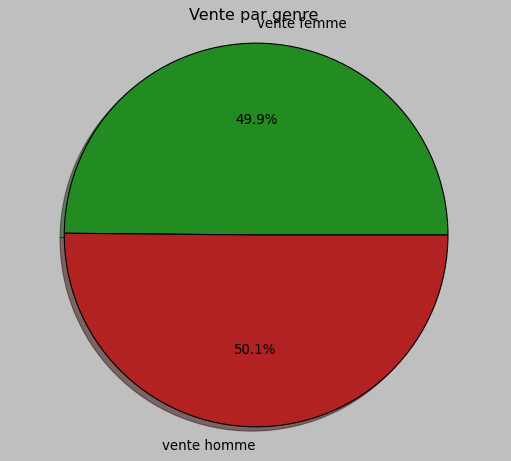

In [16]:
df_ca_f = df_final[(df_final['sex'] == 'f') & (df_final['price'] > 0)]
df_ca_m = df_final[(df_final['sex'] == 'm') & (df_final['price'] > 0)]

# Je crée un camembert pour afficher le % nombre de vente par genre
labels = 'vente femme', 'vente homme'
sizes = [len(df_ca_f), len(df_ca_m)]
colors = ['forestgreen', 'firebrick']
figS(8,6)

plt.title('Vente par genre \n')
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=0)
plt.axis('equal')
# plt.savefig('VenteCategmoinsOctobre.png', dpi=300, transparent=True)
plt.show()

### Check age 18

In [17]:
# Ici je crée un colone avec l'age
df_final['year_old'] = df_final['year_buy'] - df_final['birth']
#je filtre les 18 -
df_und_18 = df_final.loc[df_final['year_old'] <= 18]
# Je prend l'infos du prix moyen depenser par cette catégorie d'age
print('Moyenne dépense 18 :',round(df_und_18['price'].mean()))
# je check le prix max
df_und_18.sort_values(by='price', ascending=False).head()

Moyenne dépense 18 : 40


,id_prod,date,session_id,client_id,year_month_day,year_buy,Ymonth,sex,birth,price,categ,year_old
102426,2_76,2021-12-13 16:41:52,s_133825,c_665,2021-12-13,2021,2021-12,f,2004,254.44,2.0,17
621096,2_76,2021-08-12 14:52:15,s_74790,c_2791,2021-08-12,2021,2021-08,m,2004,254.44,2.0,17
579649,2_76,2022-09-12 14:52:15,s_266986,c_2791,2022-09-12,2022,2022-09,m,2004,254.44,2.0,18
100112,2_76,2022-07-12 14:52:15,s_237362,c_2791,2022-07-12,2022,2022-07,m,2004,254.44,2.0,18
69667,2_76,2022-03-12 14:52:15,s_178123,c_2791,2022-03-12,2022,2022-03,m,2004,254.44,2.0,18


In [18]:
# je regarde le meilleurs client
df_group_und_18 = df_und_18.groupby(by='client_id', sort=False)['price'].sum()
df_group_und_18.sort_values(ascending=False)

client_id
c_6977    4251.05
c_2791    3806.58
c_8159    3732.09
c_6       3646.17
c_5645    3457.84
           ...   
c_3923      34.48
c_8531      27.18
c_8527      26.23
c_8032      17.64
c_4648      11.20
Name: price, Length: 582, dtype: float64

In [19]:
# Je check les moyenne min et max
check(df_und_18.groupby(by='client_id')['price'].sum())

 Data n°1:  

 count     582.000000
mean     1035.901667
std       820.550538
min        11.200000
25%       395.367500
50%       820.220000
75%      1443.967500
max      4251.050000
Name: price, dtype: float64 




### Vente 18 ans
Sans avoir la date exact du client on va partir du principe qu'ils on 18 ans depuis x (mois/jours)

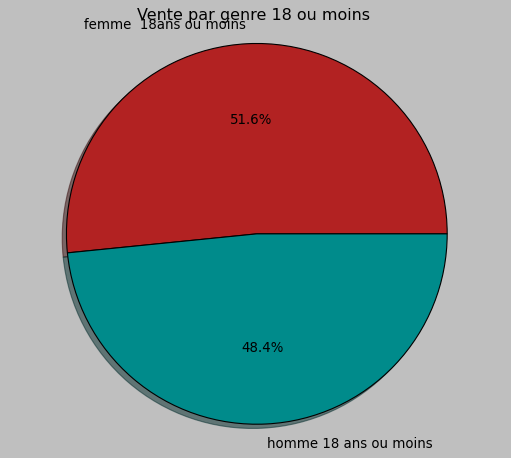

In [20]:
df_ca_f_18 = df_final[(df_final['sex'] == 'f') & (df_final['price'] > 0) & (df_final['year_buy'] - df_final['birth'] <= 18)]
df_ca_m_18 = df_final[(df_final['sex'] == 'm') & (df_final['price'] > 0) & (df_final['year_buy'] - df_final['birth'] <= 18)]

# Je crée un camembert pour afficher le % nombre de vente par genre 18 -
labels = 'femme  18ans ou moins','homme 18 ans ou moins',
sizes = [len(df_ca_f_18), len(df_ca_m_18)]
colors = ['firebrick','darkcyan']
# plt.style.use("dark_background")
figS(8,6)
plt.title('Vente par genre 18 ou moins \n')
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=0)
plt.axis('equal')
plt.show()

### Check 18 - 20

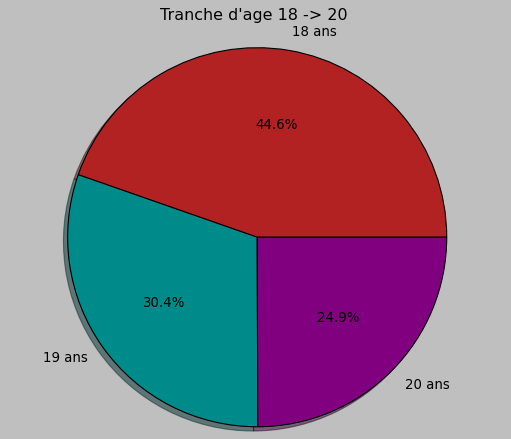

In [21]:
df_ca_18 = df_final[(df_final['price'] > 0) & (df_final['year_buy'] - df_final['birth'] == 18)]
df_ca_19 = df_final[(df_final['price'] > 0) & (df_final['year_buy'] - df_final['birth'] == 19)]
df_ca_20 = df_final[(df_final['price'] > 0) & (df_final['year_buy'] - df_final['birth'] == 20)]

# Je crée un camembert pour afficher le % nombre de vente par tranche d'age 18-20
labels = '18 ans','19 ans','20 ans',
sizes = [len(df_ca_f_18), len(df_ca_19), len(df_ca_20)]
colors = ['firebrick','darkcyan','purple']
figS(8,6)
plt.title('Tranche d\'age 18 -> 20 \n')
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=0)
plt.axis('equal')
plt.show()

## Moyenne mobile

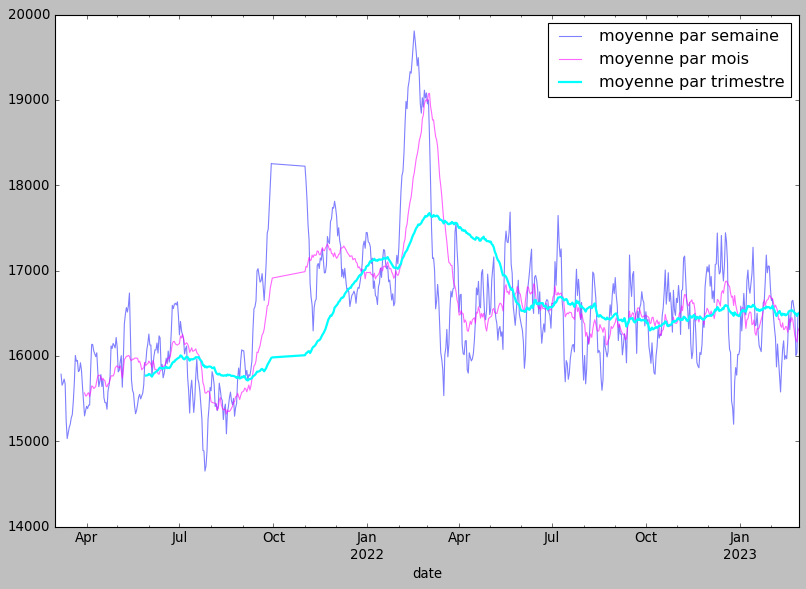

In [22]:
# Je mets ma colonne au farmat date
df_final['date'] = pd.to_datetime(df_final['date'])

# Je créer une variable qui aura un filtre sur les jours
df_period_d = df_final.date.dt.to_period('d')
# Je crée une variable ou j'applique mon filtre via un groupby
df_group = df_final.groupby(df_period_d)
# Puisque ma df est regrouper par jour.Je fait donc le total du prix par jour, ensuite j'applique une moyenne mobile via un rolling(window=X) X=7jours,30jours,90jours..
df_group_d = df_group['price'].sum().rolling(window=7).mean()
df_group_m = df_group['price'].sum().rolling(window=30).mean()
df_group_3m = df_group['price'].sum().rolling(window=90).mean()

figS(12,8)
df_group_d.plot(label='moyenne par semaine', alpha=0.5)
df_group_m.plot(label='moyenne par mois',color='magenta', alpha=0.6)
df_group_3m.plot(label='moyenne par trimestre', lw=2, color='cyan', alpha=1)
plt.legend()
# plt.savefig('moyennemobilemoinsOctobre.png', dpi=300, transparent=True)
plt.show()

# Produits
Il serait également intéressant de faire un zoom sur les références, pour voir un peu les tops et les
flops, la répartition par catégorie, etc.


In [23]:
# Je check les meilleurs produits
df_bestproduct = df_final.groupby('id_prod')['price'].sum()
df_bestproduct.sort_values(ascending=False).head()

id_prod
2_159    92265.68
2_135    67403.23
2_112    62840.10
2_102    58962.58
2_209    55362.09
Name: price, dtype: float64

## Top et Bot 5 du CA par produit

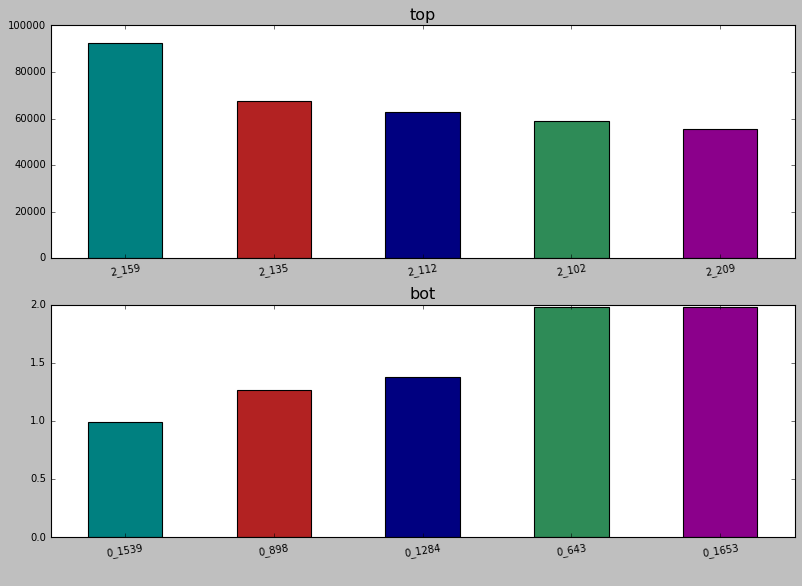

In [24]:
figS(12,8)
# Je crée 2 variable pour contenir le nombre total de mes valeur idprod que je filtre une en croissant et l'autre en décroissant
df_bproduct_sell_asc = df_bestproduct.sort_values(ascending=False)
df_bproduct_sell_desc = df_bestproduct.sort_values(ascending=True)

plt.subplot(211, title='top')
# Je selectionne les 5 premier resultat du top
df_bproduct_sell_asc.iloc[:5].plot(x=df_final['id_prod'], y=df_final.groupby(['price']).sum(),xlabel=' ', kind="bar",color=var_color, rot=9, fontsize=9)

plt.subplot(212, title='bot')
# Je selectionne les 5 dernier resultat du bot
df_bproduct_sell_desc.iloc[:5].plot(x=df_final['id_prod'], y=df_final.groupby(['price']).sum(),xlabel=' ', kind="bar",color=var_color, rot=9, fontsize=9)
# plt.savefig('TopbotprodCAmoinsOctobre.png', dpi=300, transparent=True,bbox_inches='tight')
plt.show()

## Top et Bot nombre de vente

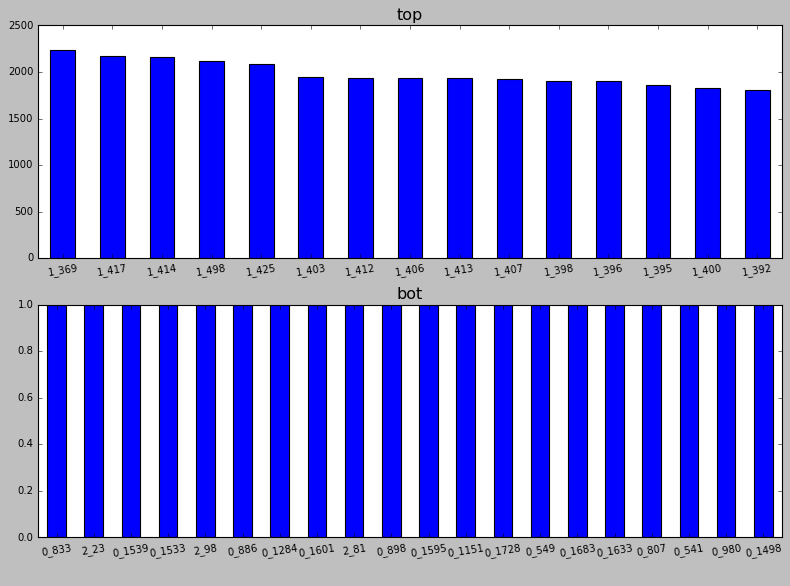

In [25]:
figS(12,8)
# Je crée 2 variable pour contenir le nombre total de mes valeur idprod que je filtre une en croissant et l'autre en décroissant
df_product_sell_asc = df_final['id_prod'].value_counts(ascending=True)
df_product_sell_desc = df_final['id_prod'].value_counts(ascending=False)

plt.subplot(211, title='top')
# Je selectionne les 15 premier resultat du top
df_product_sell_desc.iloc[:15].plot(x=df_final['id_prod'], y=df_final.groupby('id_prod').count(),xlabel=' ', kind="bar", rot=9, fontsize=9)

plt.subplot(212, title='bot')
# Je selectionne les 20 dernier resultat du bot
df_product_sell_asc.iloc[:20].plot(x=df_final['id_prod'], y=df_final.groupby('id_prod').count(),xlabel=' ', kind="bar", rot=9, fontsize=9)
# plt.savefig('TopbotprodventemoinsOctobre.png', dpi=300, transparent=True,bbox_inches='tight')
plt.show()

## Vente par catégorie de produit

### Vente catégorie all time

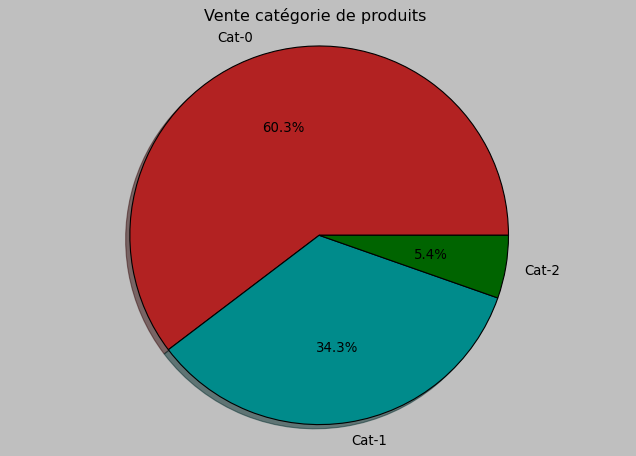

Nombre total de produit par catégorie :
Catégorie 0 : 396,697 
Catégorie 1 : 225,503
Catégorie 2 : 35,312


In [26]:
df_cat_0 = df_final[(df_final['price'] > 0) & (df_final['categ'] == 0)]
df_cat_1 = df_final[(df_final['price'] > 0) & (df_final['categ'] == 1)]
df_cat_2 = df_final[(df_final['price'] > 0) & (df_final['categ'] == 2)]

# Je crée un camembert pour afficher le % nombre de vente par vente
labels = 'Cat-0','Cat-1','Cat-2'
sizes = [len(df_cat_0), len(df_cat_1), len(df_cat_2)]
colors = ['firebrick','darkcyan','darkgreen']
figS(10,6)
plt.title('Vente catégorie de produits \n')
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=0)
plt.axis('equal')
# plt.savefig('VentecatégproduitalltimemoinsOctobre.png', dpi=300, transparent=True)
plt.show()
# Ici je print le nombre total des mes produit par catégorie pour éxpliquer plus en detail le resultat du plot
print(f"\033[1mNombre total de produit par catégorie :\033[0m\nCatégorie 0 : {len(df_cat_0):,} \nCatégorie 1 : {len(df_cat_1):,}\nCatégorie 2 : {len(df_cat_2):,}")

### Vente catégorie par ans

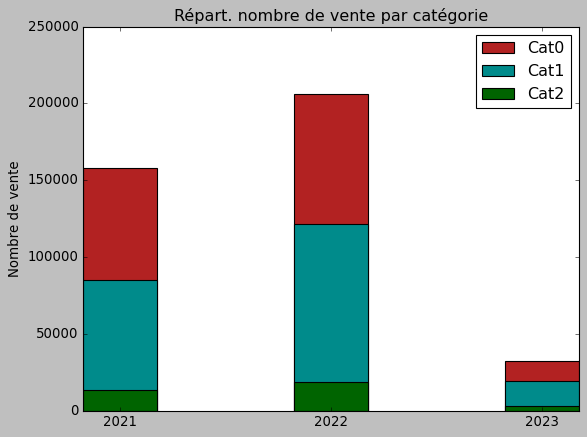

In [27]:
# je créé une fonction pour choisir la date et la catégorie pour m'éviter de devoir re-écrire la formule
def catego(data,date,categ):
    f_cat_0 = data[(data['year_buy'] == date) & (data['price'] > 0) & (data['categ'] == categ)]
    return len(f_cat_0)

labels = ['2021', '2022', '2023']
Categorie0 = [catego(df_final,2021,0), catego(df_final,2022,0), catego(df_final,2023,0)]
Categorie1 = [catego(df_final,2021,1),catego(df_final,2022,1),catego(df_final,2023,1),]
Categorie2 = [catego(df_final,2021,2),catego(df_final,2022,2),catego(df_final,2023,2),]
width = 0.35
fig, ax = plt.subplots()

ax.bar(labels, Categorie0, width,color='firebrick', label='Cat0')
ax.bar(labels, Categorie1, width,color='darkcyan',label='Cat1')
ax.bar(labels, Categorie2, width,color='darkgreen',label='Cat2')

ax.set_ylabel('Nombre de vente')
ax.set_title('Répart. nombre de vente par catégorie')
ax.legend()
# plt.savefig('RépartitionscatégansmoinsOctobre.png', dpi=300, transparent=True,bbox_inches='tight')
plt.show()

# Client

## Age H/F/total

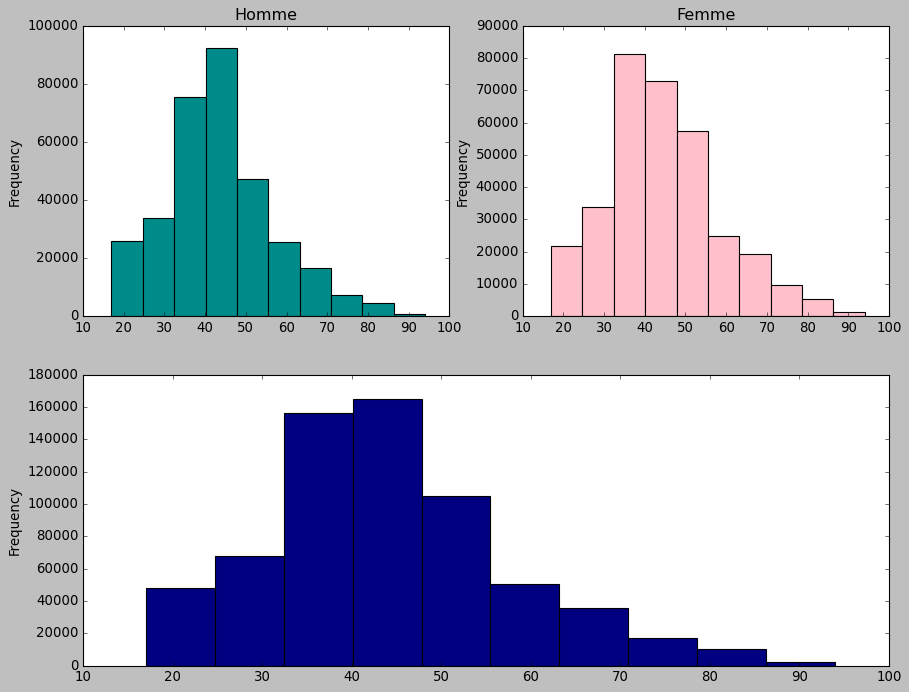

In [28]:
figS(13,10)
plt.subplot(212)
df_final['year_old'].plot(kind='hist', color='navy')
plt.subplot(221, title='Homme')
df_final[df_final['sex']== 'm']['year_old'].plot(kind='hist', color='darkcyan')
plt.subplot(222, title='Femme')
df_final[df_final['sex']== 'f']['year_old'].plot(kind='hist', color='pink')
# plt.savefig('AgeHFTotalmoinsOctobre.png', dpi=300, transparent=True,bbox_inches='tight')
plt.show()

## Nombre d'achat H/F

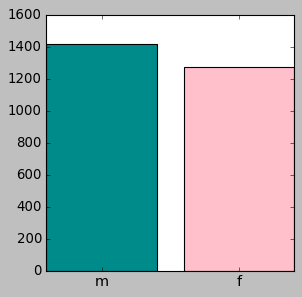

4121 <--  male / female --> 4477
Nombre de clients : 8598 / 8598

Panier moyen (CA total homme / nb client): 1415
Panier moyen (CA total femme / nb client): 1275

Bien qu'il y ait plus de clients feminin, le panier moyen ce trouve etre meilleur chez les clients masculin


In [29]:
# ici je créer 2 df avec le nombre total de client homme et femme
df_client_uni_f = df_final.loc[df_final['sex'] == 'f'].groupby(by='client_id').count()
df_client_uni_m = df_final.loc[df_final['sex'] == 'm'].groupby(by='client_id').count()

df_panier_m_moy = df_ca_m['price'].sum() / len(df_client_uni_m) #1455
df_panier_f_moy = df_ca_f['price'].sum() / len(df_client_uni_f) #1309

figS(4,4)
height = [df_panier_m_moy,df_panier_f_moy]
bars = ('m','f')
y_pos = np.arange(len(bars))

# Create bars
plt.bar(y_pos, height, color=['darkcyan', 'pink'])

# Create names on the x-axis
plt.xticks(y_pos, bars, fontsize=13)
# plt.savefig('HFnombredachatmoinsOctobre.png', dpi=300, transparent=True,bbox_inches='tight')
# Show graphic
plt.show()

print(len(df_client_uni_m),'<--  male / female -->',len(df_client_uni_f))
print('Nombre de clients :',len(df_client_uni_m) + len(df_client_uni_f),'/', len(df_final.groupby(by='client_id').count()))
print('\nPanier moyen (CA total homme / nb client):',round(df_panier_m_moy))
print('Panier moyen (CA total femme / nb client):',round(df_panier_f_moy))
print('\033[1m\nBien qu\'il y ait plus de clients feminin, le panier moyen ce trouve etre meilleur chez les clients masculin\033[0m')

## Courbe de lorenz client / prix

0.45


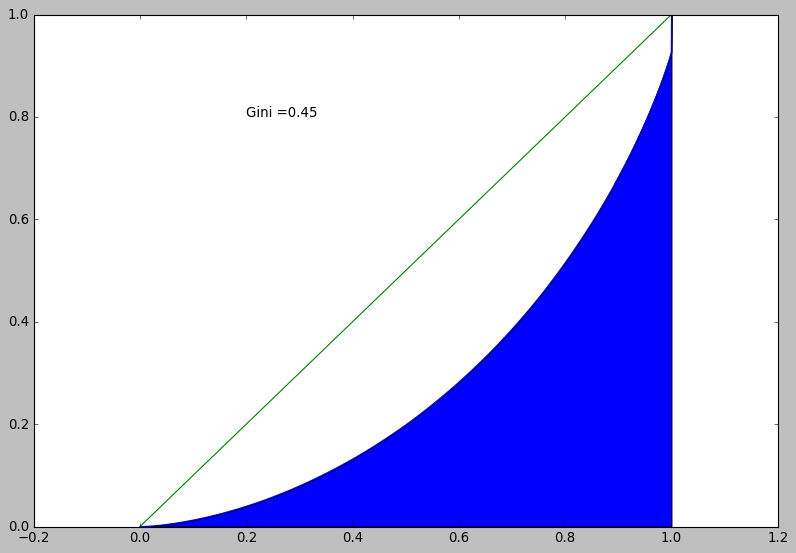

In [30]:
# je fait le chiffre d'affaires de chacun de mes client
df_ca_client = df_final.groupby(by='client_id')['price'].sum()
df_ca_client = df_ca_client.reset_index()
courbe_lorenz(df_ca_client, 'price')
# Il varie entre 0 (égalité parfaite) et 1 (inégalité extrême).

# Corrélation

## lien entre le genre d’un client et les catégories

In [31]:
# Alors ici je regroupe par sex et catégorie et je fait le CA
df_gender_cat_sum = df_final[['client_id','sex','categ','price','id_prod']]
df_gender_cat_sum = df_gender_cat_sum.groupby(by=['sex','categ'])['price'].sum().reset_index()
# Je drop mes ligne 3 et 7 qui correspondent a mes catégorie inconnu(99)
df_gender_cat_sum.drop([3, 7],inplace=True)
df_gender_cat_sum.head(500)

,sex,categ,price
0,f,0.0,2093117.08
1,f,1.0,2341981.49
2,f,2.0,1269296.09
4,m,0.0,2127363.06
5,m,1.0,2277978.88
6,m,2.0,1423193.34


In [32]:
# Alors ici je regroupe par sex et catégorie et je fait le moyenne du CA
df_gender_cat_mean = df_final[['client_id','sex','categ','price','id_prod']].copy()
df_gender_cat_mean['panier moyen'] = (df_gender_cat_mean['price'] / len(df_gender_cat_mean['client_id'])).astype(object)
df_gender_cat_mean = df_gender_cat_mean.groupby(by=['sex','categ','panier moyen'])['price'].sum().reset_index()
# # Je drop mes ligne 3 et 7 qui correspondent a mes catégorie inconnu(99)
df_gender_cat_mean.drop([3, 7],inplace=True)
df_gender_cat_mean.head(500)

,sex,categ,panier moyen,price
0,f,0.0,9.426418e-07,4.96
1,f,0.0,1.003457e-06,3.96
2,f,0.0,1.170700e-06,0.77
4,f,0.0,1.337943e-06,2.64
5,f,0.0,1.398759e-06,2.76
...,...,...,...,...
497,f,0.0,1.829029e-05,5846.58
498,f,0.0,1.830549e-05,144.48
499,f,0.0,1.836631e-05,2162.32
500,f,0.0,1.839672e-05,290.40


In [33]:
# ici je regroupe par sex et catégorie et je fait le moyenne du CA
df_gender_cat_mean = df_final[['client_id','sex','categ','price','id_prod']]
df_gender_cat_mean = df_gender_cat_mean.groupby(by=['sex','categ'])['price'].mean().reset_index()
# Je drop mes ligne 3 et 7 qui correspondent a mes catégorie inconnu(99)
df_gender_cat_mean.drop([3, 7],inplace=True)
df_gender_cat_mean.head(500)

,sex,categ,price
0,f,0.0,10.625715
1,f,1.0,20.528031
2,f,2.0,75.905758
4,m,0.0,10.652208
5,m,1.0,20.445707
6,m,2.0,76.556931


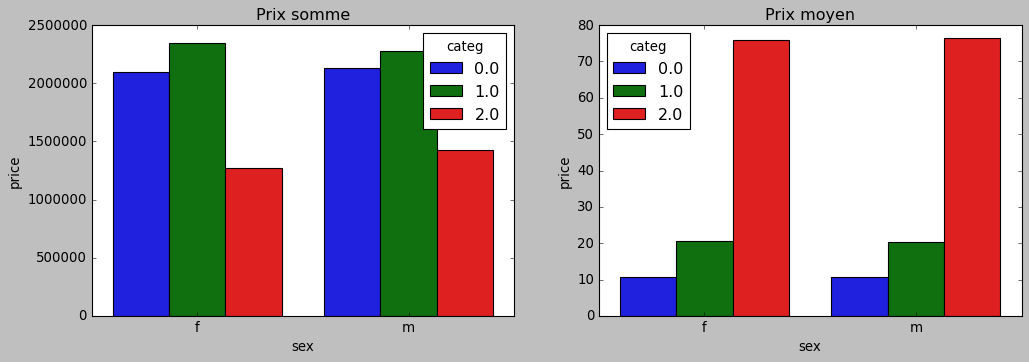

In [34]:
figS(15,10)
plt.subplot(221, title='Prix somme')
sns.barplot(y='price',x='sex',hue='categ',data=df_gender_cat_sum)
plt.subplot(222, title='Prix moyen')
sns.barplot(y='price',x='sex',hue='categ',data=df_gender_cat_mean)
plt.show()

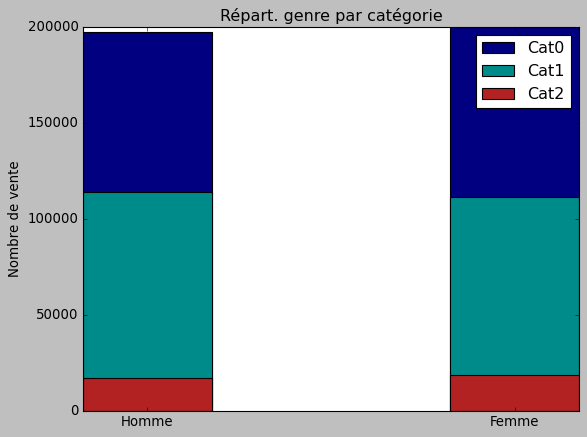

In [35]:
labels = ['Homme', 'Femme']
Categorie0 = [cat_gender(df_final,'f',0), cat_gender(df_final,'m',0)]
Categorie1 = [cat_gender(df_final,'f',1),cat_gender(df_final,'m',1)]
Categorie2 = [cat_gender(df_final,'f',2),cat_gender(df_final,'m',2)]
width = 0.35
fig, ax = plt.subplots()

ax.bar(labels, Categorie0, width,color='navy', label='Cat0')
ax.bar(labels, Categorie1, width,color='darkcyan',label='Cat1')
ax.bar(labels, Categorie2, width,color='firebrick',label='Cat2')

ax.set_ylabel('Nombre de vente')
ax.set_title('Répart. genre par catégorie')
ax.legend()

plt.show()


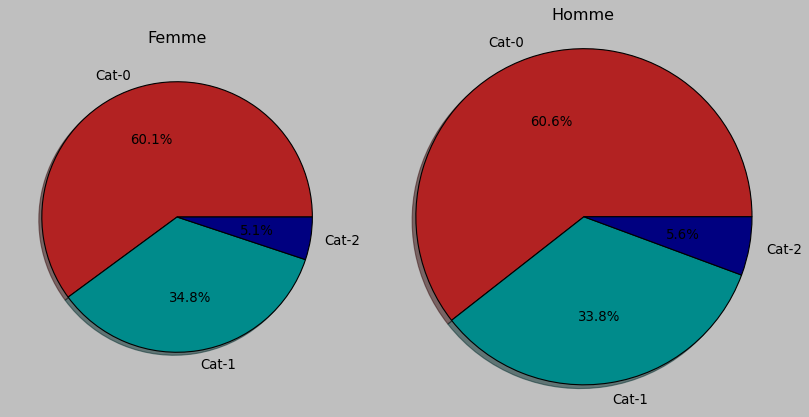

In [36]:
figS(12,6)
# Je crée un camembert pour afficher le % nombre de vente par vente
labels = 'Cat-0','Cat-1','Cat-2'
sizef = [cat_gender(df_final,'f',0), cat_gender(df_final,'f',1), cat_gender(df_final,'f',2)]
sizem = [cat_gender(df_final,'m',0), cat_gender(df_final,'m',1), cat_gender(df_final,'m',2)]
colors = ['firebrick','darkcyan','navy']

plt.subplot(121,title='Femme')
plt.pie(sizef, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=0)

plt.subplot(122,title='Homme')
plt.pie(sizem, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=0)
plt.axis('equal')
plt.show()

### Corrélation genre Catégorie

H0: Il n'y a pas de liens entre la catégorie de livre acheter et le sex du client
H1: Il y a un liens entre la catégorie de livre acheter et le sex du client
% d'erreur 5% = Table 3,841

In [37]:
df_final.groupby('client_id').sum()

,year_buy,birth,price,categ,year_old
client_id,,,,,
c_1,76820,74290,550.19,10.0,2530
c_10,117253,113448,1353.60,42.0,3805
c_100,16170,15936,254.85,7.0,234
c_1000,246652,239852,2209.92,80.0,6800
c_1001,194079,190272,1720.08,33.0,3807
...,...,...,...,...,...
c_995,28300,27370,189.41,3.0,930
c_996,190037,185180,1611.59,55.0,4857
c_997,117263,115652,1432.02,49.0,1611


In [38]:
# je crée un copy de mon df_dinal ou je retire la categ 99
df_drop_categ_99 = df_final.copy()
df_drop_categ_99.drop(df_drop_categ_99.index[df_drop_categ_99['categ'] == 99.0], inplace=True)

# Ici je drop mes 4 plus gros clients
df_drop_categ_99.drop(df_drop_categ_99.index[(df_drop_categ_99['client_id'] == 'c_1609') | (df_drop_categ_99['client_id'] == 'c_4958') | (df_drop_categ_99['client_id'] == 'c_6714') | (df_drop_categ_99['client_id'] == 'c_3454')] , inplace=True)

df_test = df_drop_categ_99.groupby(['categ','sex']).sum().reset_index()
df_test = df_test[['categ','sex','price']]
# Je crée ma table avec margins=True pour avoir le total de chaque lignes et colonnes
var_calcul = pd.crosstab(df_drop_categ_99['sex'],df_drop_categ_99['categ'])
var_calcul

categ,0.0,1.0,2.0
sex,,,
f,191919,110550,16429
m,177945,100227,15351


**La somme total d'homme est de : 340,826
La somme total de femme est de : 338,285
La somme total de la catégorie 0 est de : 415,459
La somme total de la catégorie 1 est de : 227,169
La somme total de la catégorie 2 est de : 36,483**

In [39]:
# Je crée ma table normaliser
df_sex_categ = pd.crosstab(df_drop_categ_99['sex'],df_drop_categ_99['categ'],normalize=True)
df_sex_categ

categ,0.0,1.0,2.0
sex,,,
f,0.313378,0.180513,0.026826
m,0.290560,0.163657,0.025066


In [40]:
# (147.11906816131497, 2, 1.1310980597090762e-32) (0.0002166347889539628, 2, 0.9998916884716402) sans le drop client
# (20.213460693513895, 2, 4.080400389217356e-05) (3.195920277498468e-05, 2, 0.9999840205262857) avec le drop client
stats.chi2_contingency(df_sex_categ)

(3.06156973445872e-05,
 0.9999846922684922,
 2,
 array([[0.31448049, 0.17921521, 0.02702126],
        [0.289457  , 0.1649549 , 0.02487115]]))

pvalues = 0,999 / table = 0,0020 ? (ddl 2)

5% = 5,9915 ( Mon resultat d'hypothese rejeter si mon test chi-2 est inferieur ou superieur ?( Valider si inferieur ou superieur ?)

## Age clients et montant total des achats

In [41]:
# je check mes colonne cleint age.
df_final.groupby(['client_id','year_old'])['price'].sum()

client_id  year_old
c_1        66           286.67
           67           219.23
           68            44.29
c_10       65           586.18
           66           602.93
                        ...   
c_998      21          1179.06
           22           498.96
c_999      57           206.63
           58           394.11
           59            80.69
Name: price, Length: 24176, dtype: float64

In [69]:
# Cette formule est bien si je dois trouver le lien entre age et montant total achat de client precis
# df_yo_ca = df_yo_ca.groupby(['client_id']).agg({'price':np.sum, 'year_old':np.mean}).reset_index()


# Je crée ma df ou je regoupe pas Age et je fait la sum()
df_yo_ca = df_drop_categ_99.groupby('year_old').sum().reset_index() # cette formule est mieux car je prend just l'age auquelle j'ajoute le prix total

# j'arrondi valeur au dessus
df_yo_ca['year_old'] = df_yo_ca['year_old'].round()
df_yo_ca['price'] = df_yo_ca['price'].round()

df_yo_ca.head()

,year_old,year_buy,birth,price,categ
0,17,11226655,11132220,223666.0,6478.0
1,18,19213414,19042360,379228.0,11183.0
2,19,10694007,10593516,216490.0,6336.0
3,20,8772259,8685479,172955.0,5088.0
4,21,8468891,8380922,167639.0,4838.0


In [70]:
# je check mes valeur price et age.
df_yo_ca.sort_values(by='price',ascending=False)
# df_yo_ca.sort_values(by='year_old',ascending=False)

,year_old,year_buy,birth,price,categ
1,18,19213414,19042360,379228.0,11183.0
26,43,47885541,46867043,318334.0,6091.0
25,42,44219097,43300431,293388.0,5539.0
27,44,44767397,43793105,292209.0,5384.0
17,34,42947285,42225023,282018.0,5200.0
...,...,...,...,...,...
73,90,479177,457847,3990.0,150.0
74,91,416475,397729,3400.0,116.0
75,92,392221,374373,3285.0,130.0
76,93,260852,248855,2116.0,88.0


             price  year_old
price     1.000000 -0.885403
year_old -0.885403  1.000000

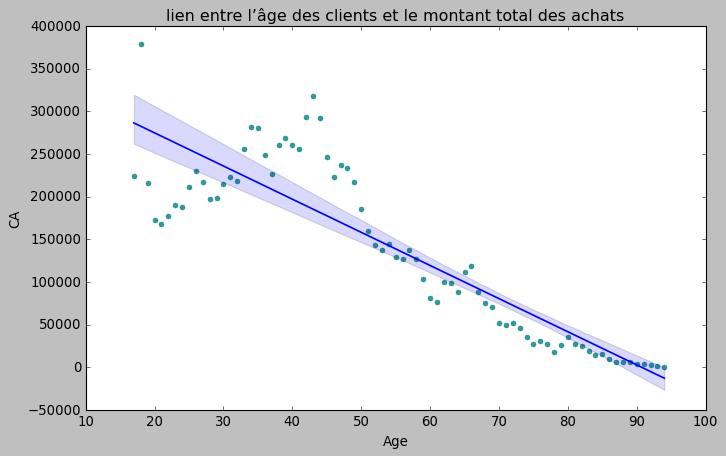

In [71]:
figS(10,6)
sns.regplot(y=df_yo_ca['price'], x=df_yo_ca['year_old'],scatter_kws={'color':'teal'})
plt.title('lien entre l’âge des clients et le montant total des achats')
plt.ylabel('CA')
plt.xlabel('Age')

# print de ma correlation prix age
print(df_yo_ca[['price','year_old']].corr(), end='')

In [72]:
#Test de corrélation de pearson
corr, _ = pearsonr(df_yo_ca['price'], df_yo_ca['year_old'])
print('Pearsons correlation: %.4f' % corr)

Pearsons correlation: -0.8854


Donc le test de corrélation de peasrons prend 0 quand il n'y a pas de liens.
Donc avec -0.8566 j'ai une forte relation négative.
Donc pour moi cela serait plus l'age augmente plus les prix baisse.

H0 : le montant total des achat n'a pas de lien avec l'age du client
H1 : le montant total des achat a un lien avec l'age du client

## Age client et fréquense d'achat

In [46]:
#Je pars du principe qu'une session aboutie a une vente
#Donc je crée ma variable qui regoupe l'age de tout mes clients et je compte combien de session par age
df_client_achat = df_drop_categ_99.groupby('year_old').count().reset_index()
df_client_achat = df_client_achat[['year_old', 'session_id']]

#Fréquence d’achat = Nombre total de commandes / Nombre de clients uniques
#Ex: Age 94 = Total session 23 / Total session.sum()
df_client_achat['frequence'] = df_client_achat['session_id']/df_client_achat['session_id'].sum()
df_client_achat.sort_values(by='year_old', ascending=False).head()

,year_old,session_id,frequence
77,94,23,0.000038
76,93,129,0.000211
75,92,194,0.000317
74,91,206,0.000336
73,90,237,0.000387


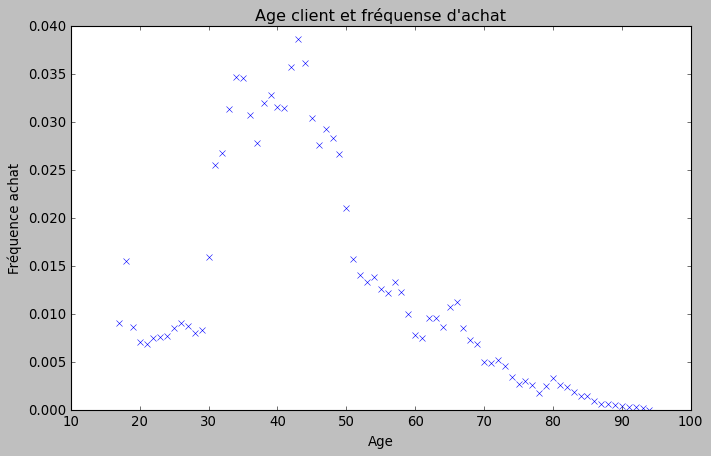

In [47]:
figS(10,6)
plt.plot(df_client_achat['year_old'], df_client_achat['frequence'], 'x')
plt.ylabel('Fréquence achat')
plt.xlabel('Age')
plt.title('Age client et fréquense d\'achat')
plt.show()

           frequence  year_old
frequence    1.00000  -0.57771
year_old    -0.57771   1.00000

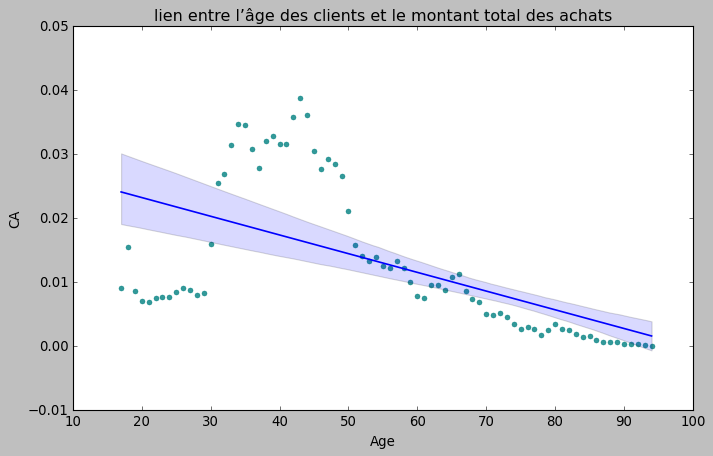

In [48]:
figS(10,6)
sns.regplot(y=df_client_achat['frequence'], x=df_client_achat['year_old'],scatter_kws={'color':'teal'})
plt.title('lien entre l’âge des clients et le montant total des achats')
plt.ylabel('CA')
plt.xlabel('Age')

#print de ma correlation
print(df_client_achat[['frequence','year_old']].corr(), end='')

In [49]:
corr, _ = pearsonr(df_client_achat['year_old'], df_client_achat['frequence'])
print('Pearsons correlation: %.4f' % corr)

Pearsons correlation: -0.5777


Donc le test de corrélation de peasrons prend 0 quand il n'y a pas de liens.
Donc avec -0.5554 j'ai une relation négative.
Donc pour moi oui il y a un lien entre l'age du client et la frequence d'achat

H0 : il n'y a pas de lien entre l'age du client et la frequence d'achat
H1 : il y a un lien entre l'age du client et la frequence d'achat

## Age client et panier moyen

pour la taille du panier moyen, comme il était écrit "taille", j'ai pris le nombre d'articles.

In [50]:
#Donc je crée ma variable que je regroupre par age et session(pour avoir mes articles unique) et je fais un count() pour avoir mes infos article
df_client_pm = df_drop_categ_99.groupby(['year_old', 'session_id']).count().reset_index()
#sum price

#Puis je regroupe par age et je fait la moyenne d'article
df_client_pm = df_client_pm.groupby('year_old').mean().reset_index()
df_client_pm = df_client_pm[['year_old', 'id_prod']]
df_client_pm.head()

,year_old,id_prod
0,17,1.762373
1,18,1.760467
2,19,1.739803
3,20,1.766694
4,21,1.766020


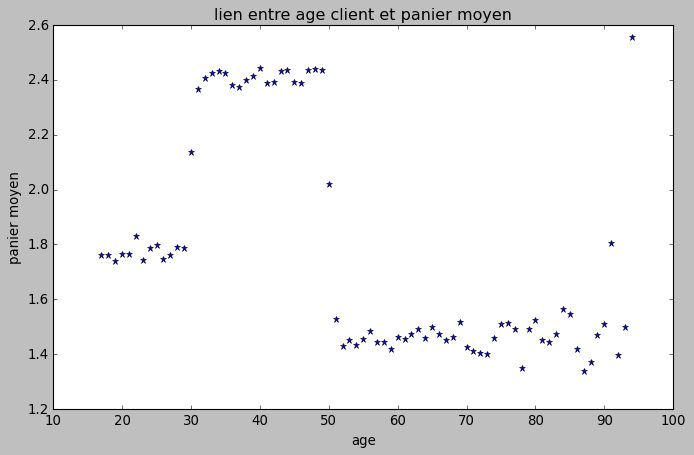

In [51]:
figS(10,6)
plt.plot(df_client_pm['year_old'], df_client_pm['id_prod'], '*')
plt.ylabel('panier moyen')
plt.xlabel('age')
plt.title('lien entre age client et panier moyen')
plt.show()

           id_prod  year_old
id_prod   1.000000 -0.531196
year_old -0.531196  1.000000

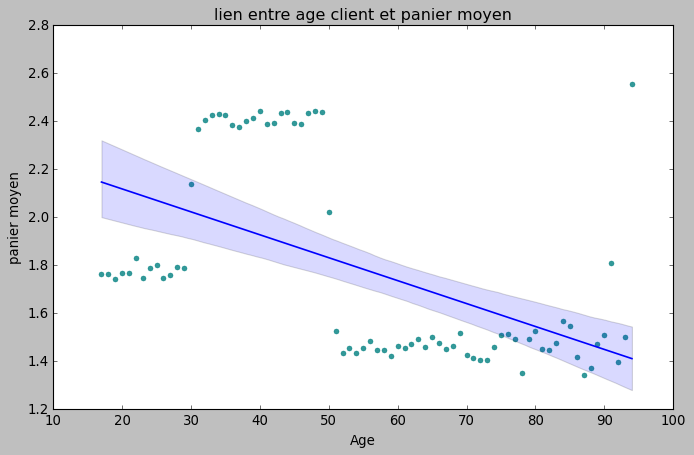

In [52]:
figS(10,6)
sns.regplot(y=df_client_pm['id_prod'], x=df_client_pm['year_old'],scatter_kws={'color':'teal'})
plt.title('lien entre age client et panier moyen')
plt.ylabel('panier moyen')
plt.xlabel('Age')

#print de ma correlation
print(df_client_pm[['id_prod','year_old']].corr(), end='')

In [53]:
corr, _ = pearsonr(df_client_pm['year_old'], df_client_pm['id_prod'])
print('Pearsons correlation: %.4f' % corr)

Pearsons correlation: -0.5312


Donc le test de corrélation de peasrons prend 0 quand il n'y a pas de liens.
Donc avec -0.517347 j'ai une relation négative.
Donc pour moi oui il y a un lien entre certainne catégorie d'age et le panier moyen (18-30ans , 30-50ans , 50~90+ans)

H0 : il n'y a pas de lien entre l'age du client et le panier moyen
H1 : il y a un lien entre l'age du client et le panier moyen

## Age et catégorie des livres achetés

In [54]:
for i in df_final.sort_values('year_old')['year_old'].unique():
    df= df_final.loc[df_final['year_old'] == i]
    fit = statsmodels.formula.api.ols('year_old ~ categ',data = df).fit()
    table = statsmodels.api.stats.anova_lm(fit)
    table['H0']= table['PR(>F)'] > 0.05
    print('pour les personnes agées de',i,'ans, H0 est ',table.iloc[0][5])

pour les personnes agées de 17 ans, H0 est  False
pour les personnes agées de 18 ans, H0 est  True
pour les personnes agées de 19 ans, H0 est  False
pour les personnes agées de 20 ans, H0 est  True
pour les personnes agées de 21 ans, H0 est  False
pour les personnes agées de 22 ans, H0 est  True
pour les personnes agées de 23 ans, H0 est  True
pour les personnes agées de 24 ans, H0 est  True
pour les personnes agées de 25 ans, H0 est  False
pour les personnes agées de 26 ans, H0 est  True
pour les personnes agées de 27 ans, H0 est  True
pour les personnes agées de 28 ans, H0 est  True
pour les personnes agées de 29 ans, H0 est  True
pour les personnes agées de 30 ans, H0 est  True
pour les personnes agées de 31 ans, H0 est  True
pour les personnes agées de 32 ans, H0 est  True
pour les personnes agées de 33 ans, H0 est  False
pour les personnes agées de 34 ans, H0 est  False
pour les personnes agées de 35 ans, H0 est  False
pour les personnes agées de 36 ans, H0 est  False
pour les per

In [55]:
# ici je vais chercher ma dataframe ou la categ 99 a était drop. Puis je regoupe par age et caté et je compte le nombre de session car comme plus tot une session = un achat
df_year_categ = df_drop_categ_99.groupby(['year_old', 'categ']).count().reset_index()
df_year_categ = df_year_categ[['year_old', 'categ', 'session_id']]
df_year_categ.head()

,year_old,categ,session_id
0,17,0.0,1265
1,17,1.0,2102
2,17,2.0,2188
3,18,0.0,2059
4,18,1.0,3705


<a href="https://medium.com/analytics-vidhya/customer-demographics-segmentation-analysis-with-simple-python-cdd2e6d35f2e">Médium pour le split d'age</a>

In [56]:
# ici j'utilise cut() ou je split mes catégorie par parametre bins( tranche d'age que j'ai utiliser plus tot dans mon chiffre d'affaires)
df_year_categ['year_old']= pd.cut(df_year_categ['year_old'], bins = [18,25,35,45,55,70,80,90,150], labels= ['18-25','26-35','36-45','46-55','56-70','71-80','81-90','90+'])
# Je regroupe par age et categ puis je fait la somme de mes sesssion
df_year_categ = df_year_categ.groupby(['year_old','categ']).sum().reset_index()
df_year_categ.head(500)

,year_old,categ,session_id
0,18-25,0.0,7381
1,18-25,1.0,12568
2,18-25,2.0,13062
3,26-35,0.0,80905
4,26-35,1.0,33066
5,26-35,2.0,10320
6,36-45,0.0,150682
7,36-45,1.0,49053
8,36-45,2.0,724
9,46-55,0.0,78533


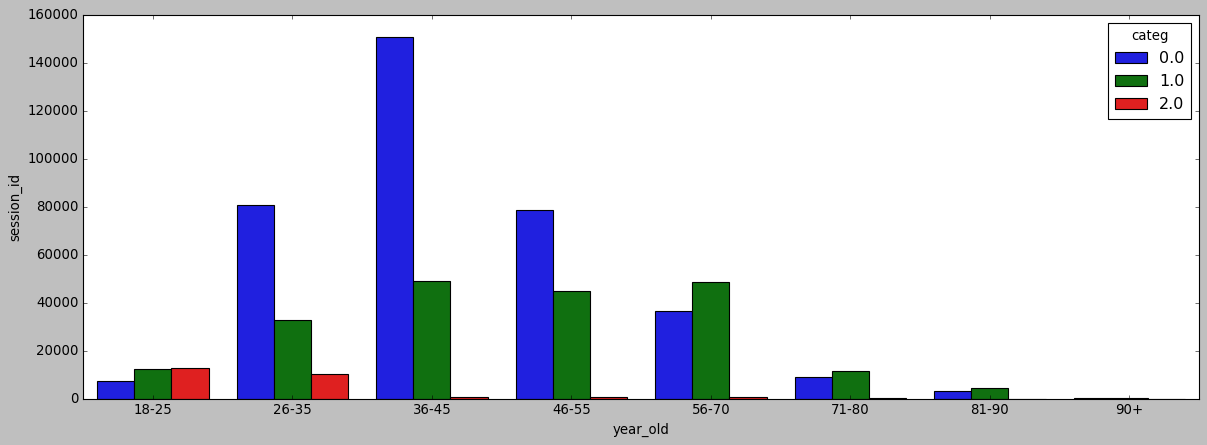

In [57]:
figS(18,6)
sns.barplot(x='year_old', y='session_id',hue='categ', data=df_year_categ)
ax.set_title('Distribution of Spending Score by Age Group')
plt.show()

In [58]:
# Méthod ANOVA pour les valeur qualitative x quantitative
X = "year_old" # qualitative
Y = "session_id" # quantitative

def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

eta_squared(df_year_categ['year_old'],df_year_categ['session_id'])

0.3869100652043526

In [59]:
from scipy import stats as mystats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
mymodel=ols('session_id ~ year_old',df_year_categ).fit()
anova_table=anova_lm(mymodel)
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
year_old,7.0,1.180789e+10,1.686841e+09,1.442473,0.256159
Residual,16.0,1.871054e+10,1.169409e+09,NaN,NaN


# Total d'achat client & client/catégorie

Age moyen des Femmes 44 ans 
Age moyen des Hommes 43 ans

Age médian des Femmes 43 ans 
Age médian des Hommes 42 ans



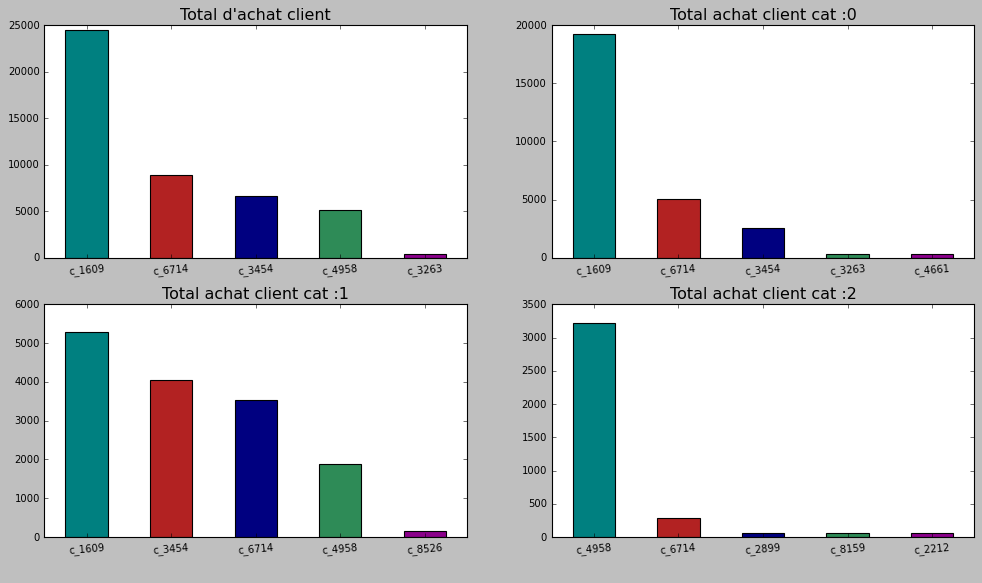

In [60]:
print("Age moyen des Femmes",round(df_final[(df_final['sex'] == 'f')]['year_old'].mean()),'ans',"\nAge moyen des Hommes",round(df_final[(df_final['sex'] == 'm')]['year_old'].mean()),'ans', end='\n\n')
print("Age médian des Femmes",round(df_final[(df_final['sex'] == 'f')]['year_old'].median()),'ans',"\nAge médian des Hommes",round(df_final[(df_final['sex'] == 'm')]['year_old'].median()),'ans' ,end='\n\n')

df_client_buy = df_final['client_id'].value_counts(ascending=False)
df_client_buy_cat0 = df_final[df_final['categ'] == 0].value_counts('client_id',ascending=False)
df_client_buy_cat1 = df_final[df_final['categ'] == 1].value_counts('client_id',ascending=False)
df_client_buy_cat2 = df_final[df_final['categ'] == 2].value_counts('client_id',ascending=False)

plt.figure(figsize=(15,8))
plt.subplot(221,title='Total d\'achat client')
df_client_buy.iloc[:5].plot(x=df_final['client_id'], y=df_final.groupby('client_id').count(), kind="bar",color=var_color, rot=5, fontsize=9)

plt.subplot(222,title='Total achat client cat :0')
df_client_buy_cat0.iloc[:5].plot(x=df_final['client_id'], y=df_final.groupby('client_id').count(),xlabel=' ', kind="bar",color=var_color, rot=5, fontsize=9)

plt.subplot(223,title='Total achat client cat :1')
df_client_buy_cat1.iloc[:5].plot(x=df_final['client_id'], y=df_final.groupby('client_id').count(),xlabel=' ', kind="bar",color=var_color, rot=5, fontsize=9)

plt.subplot(224,title='Total achat client cat :2')
df_client_buy_cat2.iloc[:5].plot(x=df_final['client_id'], y=df_final.groupby('client_id').count(),xlabel=' ', kind="bar",color=var_color, rot=5, fontsize=9)
# plt.savefig('ClientotalcatmoinsOctobre.png', dpi=300, transparent=True,bbox_inches='tight')
plt.show()

<AxesSubplot:title={'center':'Total achat client cat :2'}, xlabel=' '>

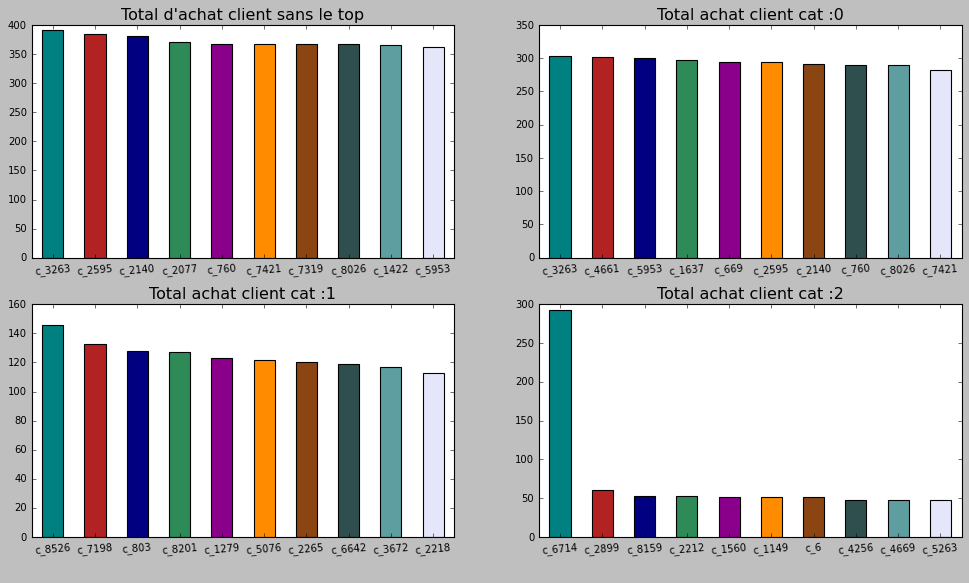

In [61]:
# Ici je retire les top client des plot précédent
plt.figure(figsize=(15,8))
plt.subplot(221,title='Total d\'achat client sans le top')
df_client_buy.iloc[4:14].plot(x=df_final['sex'], y=df_final.groupby('sex').count(), kind="bar",color=var_color, rot=5, fontsize=9)

plt.subplot(222,title='Total achat client cat :0')
df_client_buy_cat0.iloc[3:13].plot(x=df_final['client_id'], y=df_final.groupby('client_id').count(),xlabel=' ', kind="bar",color=var_color, rot=5, fontsize=9)

plt.subplot(223,title='Total achat client cat :1')
df_client_buy_cat1.iloc[4:14].plot(x=df_final['client_id'], y=df_final.groupby('client_id').count(),xlabel=' ', kind="bar",color=var_color, rot=5, fontsize=9)

plt.subplot(224,title='Total achat client cat :2')
df_client_buy_cat2.iloc[1:11].plot(x=df_final['client_id'], y=df_final.groupby('client_id').count(),xlabel=' ', kind="bar",color=var_color, rot=5, fontsize=9)
# plt.savefig('topclientsansgrosmoinsOctobre.png', dpi=300, transparent=True,bbox_inches='tight')

In [62]:
# minnimum transaction par un client '1' et maximum 25488
df_client_buy.describe()

count     8598.000000
mean        76.497558
std        300.908902
min          1.000000
25%         26.000000
50%         50.000000
75%         93.000000
max      24472.000000
Name: client_id, dtype: float64

# Corrélations

In [63]:
df_final.corr()

,year_buy,birth,price,categ,year_old
year_buy,1.000000,0.000141,0.009464,0.005939,0.045011
birth,0.000141,1.000000,0.208660,0.030887,-0.998980
price,0.009464,0.208660,1.000000,0.212708,-0.208021
categ,0.005939,0.030887,0.212708,1.000000,-0.030587
year_old,0.045011,-0.998980,-0.208021,-0.030587,1.000000


In [64]:
df_final.corr(method='kendall')

C:\Users\dams_\anaconda3\lib\site-packages\scipy\stats\stats.py:4812: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


,year_buy,birth,price,categ,year_old
year_buy,1.000000,0.000048,0.010671,0.019423,0.040327
birth,0.000048,1.000000,0.032999,0.021442,-0.983158
price,0.010671,0.032999,1.000000,0.575809,-0.032644
categ,0.019423,0.021442,0.575809,1.000000,-0.020785
year_old,0.040327,-0.983158,-0.032644,-0.020785,1.000000


In [65]:
df_final.corr(method='spearman')

,year_buy,birth,price,categ,year_old
year_buy,1.000000,0.000062,0.013410,0.020484,0.050200
birth,0.000062,1.000000,0.054184,0.035358,-0.998348
price,0.013410,0.054184,1.000000,0.688763,-0.053694
categ,0.020484,0.035358,0.688763,1.000000,-0.034576
year_old,0.050200,-0.998348,-0.053694,-0.034576,1.000000


Text(0.5, 1.0, 'Correlation')

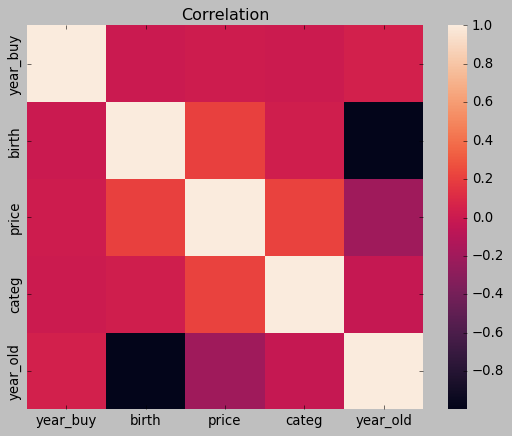

In [66]:
sns.heatmap(df_final.corr()).set_title('Correlation')
# plt.savefig('heatmapcorrmoinsOctobre.png', dpi=300, transparent=True,bbox_inches='tight')

In [67]:
def correlations(data):
    plt.figure(figsize=(12,8))
    mask = np.triu(np.ones_like(data.corr(), dtype=bool))
    sns.heatmap(data.corr(),mask=mask,center=0,cmap='RdBu',linewidths=1, annot=True, fmt='.2f', vmin=-1, vmax=1).set_title('Correlation')
    plt.title('Corrélation')
    # plt.savefig('heatcorrmoinsOctobre.png', dpi=300, transparent=True,bbox_inches='tight')
    plt.show()

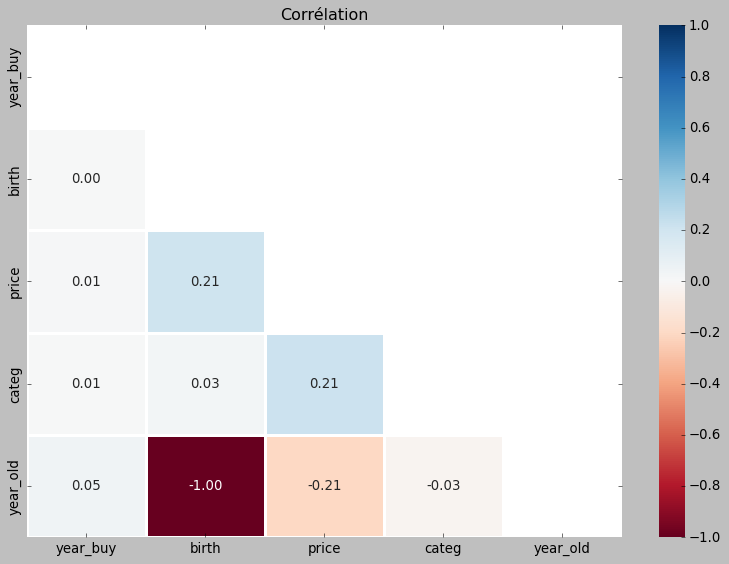

In [68]:
correlations(df_final)